In [1]:
import sys
sys.path.append('/home/fenglab/Desktop/transdiff_GRN/src/')

from find_modules import *
from topology import *

In [2]:
import seaborn as sns
from scipy import stats

random_s = 10
random.seed(random_s)

In [3]:
with open('./../data/count_matrix.csv', 'r') as f:
    lines = f.readlines()
entrez_ids = {line.split(',')[0]:line.split(',')[2] for line in lines[1:]}

with open('./../data/QuickGO-annotations-TFs.tsv', 'r') as f:
    lines = f.readlines()
tfs = [line.split('\t')[2] for line in lines[1:]]

with open('./../data/grn_expression.txt', 'r') as f:
    lines = f.readlines()
genes = [line.split('\t')[0] for line in lines[1:]]

grntfs = list(set(tfs)&set(genes))

In [4]:
treatments = ['Anp', 'AMn', 'AMp', 'AMnp']

def go_plot(community_no):
    # gene ontology bar plot
    dfannots = pd.read_csv(f'./../results/temp/{str(community_no)}.csv')
    if len(dfannots.T)>1:
        #dfannots = dfannots[dfannots['p.adjust']<0.01]
        dfannots['refgs'] = [int(n.split('/')[0]) for n in dfannots['BgRatio']]
        dfannots = dfannots[(dfannots['refgs']<1500)&(dfannots['refgs']>10)]
        dfannots = dfannots.drop_duplicates(subset='geneID', keep='first')
        dfannots = dfannots[:10]
        dfannots = dfannots.sort_values(by=['p.adjust'], ascending=False)
        if len(dfannots)>=1:
            if len(dfannots)>1:
                fig = plt.figure(figsize=(2, 1.5*np.log(len(dfannots))))
            else:
                fig = plt.figure(figsize=(2, 0.4))
            ax = fig.add_subplot(1, 1, 1)
            ylabels = [yl.replace('projection', 'proj.') for yl in list(dfannots['Description'])]
            ylabels = [yl.replace('regulation', 'reg.') for yl in ylabels]
            plt.barh(ylabels, -np.log10(dfannots['p.adjust']), 
                    color=colors[community_no], alpha=0.2, edgecolor=colors[community_no], linewidth=2)
            plt.barh(ylabels, -np.log10(dfannots['p.adjust']), 
                    color='none', alpha=0.7, edgecolor=colors[community_no], linewidth=2)
            plt.yticks(fontsize=15)
            plt.title(str(community_no), fontsize=15)
            plt.xlabel('-log'+r'$_{10}$'+'(FDR)', fontsize=15)
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
    return

In [5]:
DG = read_directed_grn(f'./../results/GRN/{treatments[0]}_7.txt')
DGp = remove_edge(DG, 0.4, component='positive')
print(f'edges {len(DGp.edges())}')
print(f'nodes {len(DGp.nodes())}')
print(f'''mean weight {np.sum([w for _, _, w in list(DGp.edges.data('weight'))])/len(DGp.edges())}''')
print(f'mean degree {np.sum(list(dict(DGp.degree()).values()))/len(DGp.nodes())}')

edges 1679
nodes 323
mean weight 0.4780494712113292
mean degree 10.396284829721361


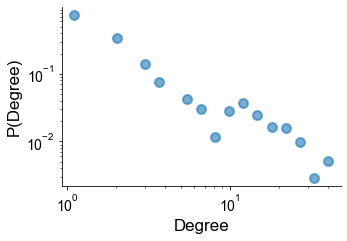

In [6]:
x1, y1 = plot_degree(DGp, n_bins=20)
fig = plt.figure(figsize=(5,3.3))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(x1,y1, 'o', markersize=9, markeredgecolor='tab:blue', markeredgewidth=2, alpha=0.6)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Degree', fontsize=17)
plt.ylabel('P(Degree)', fontsize=17)
plt.savefig('./../figs/S5A.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

In [7]:
part = louvain_cluster(DGp, random_state=True, random_s=random_s)
clustergo(part)

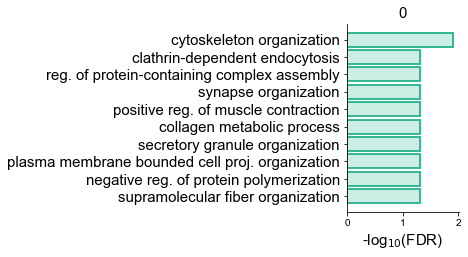

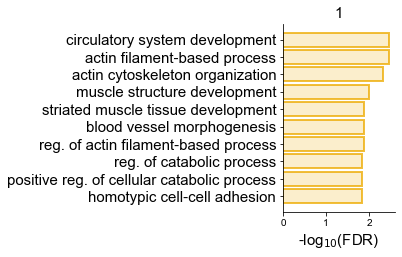

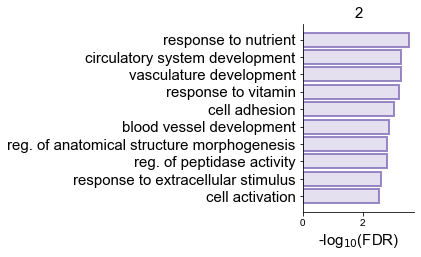

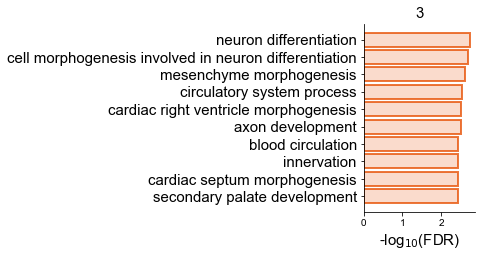

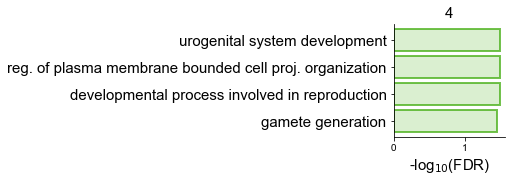

In [8]:
for n in np.unique(list(part.values())):
    go_plot(n)
    plt.savefig(f'./../figs/5A_{n}.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

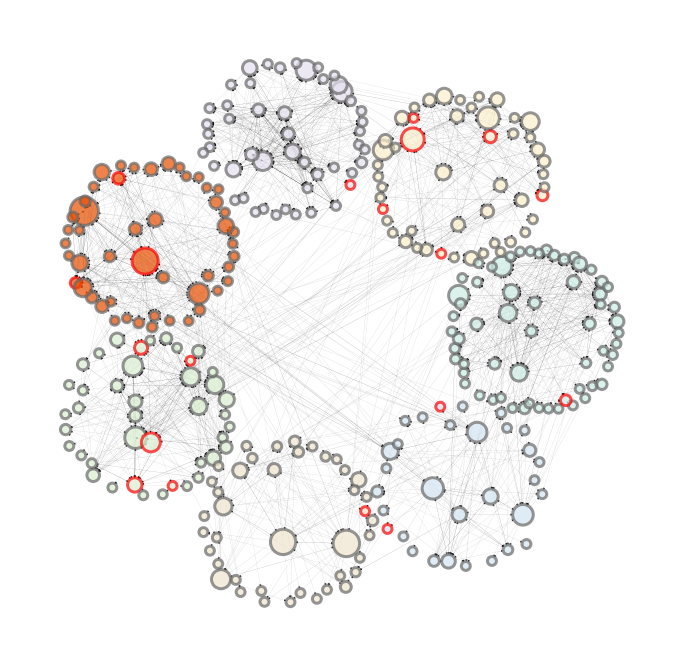

In [9]:
pos = community_layout(DGp, partition=part, scales_c=2.4, scales_n=1.8)
fig, ax = plt.subplots(figsize=(12, 12))
edge_colors = highlight_cmap(list(DGp.nodes()),grntfs)

node_size = np.array(list(nx.betweenness_centrality(DGp, seed=random_s).values()))*8000+80
edge_width = np.array(list(nx.get_edge_attributes(DGp, 'weight').values()))
#cmap = get_cmap(part, highlight=False)
cmap = get_cmap(part, highlight=True, modulelist=[3], alpha=0.8)
node_color=[cmap[v] for v in list(part.values())]

nodes = nx.draw_networkx_nodes(DGp, pos, node_color=node_color, edgecolors=edge_colors,
                               node_size=node_size, alpha=0.7, linewidths=3)
edges = nx.draw_networkx_edges(DGp, pos, node_size=node_size,
                               width=0.1*edge_width, edge_color='black', arrowsize=5)

ax.set_axis_off()
plt.savefig('./../figs/5A.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

In [10]:
dffig = pd.DataFrame(zip(list(DGp.nodes()), node_size, edge_colors, list(part.values())), 
columns=['geneid', 'rank', 'istf', 'community'])
dffig[dffig['istf']=='#fc0303'].sort_values(by=['rank'], ascending=False)[:3]

,geneid,rank,istf,community
11,OTX2,680.838354,#fc0303,3
30,CEBPA,524.738447,#fc0303,1
44,TCF3,358.484633,#fc0303,4


In [11]:
dffig[dffig['istf']!='#fc0303'].sort_values(by=['rank'], ascending=False)[:3]

,geneid,rank,istf,community
10,CHRNB4,805.666983,#696969,3
76,ADAMTS4,701.221436,#696969,5
113,IGFBP3,639.648340,#696969,5


In [12]:
DG = read_directed_grn(f'./../results/GRN/{treatments[1]}_1.txt')
DGp = remove_edge(DG, 0.45, component='positive')
print(f'edges {len(DGp.edges())}')
print(f'nodes {len(DGp.nodes())}')
print(f'''mean weight {np.sum([w for _, _, w in list(DGp.edges.data('weight'))])/len(DGp.edges())}''')
print(f'mean degree {np.sum(list(dict(DGp.degree()).values()))/len(DGp.nodes())}')

edges 1295
nodes 400
mean weight 0.5292210658885618
mean degree 6.475


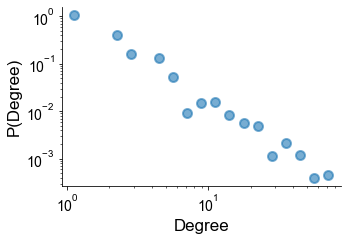

In [13]:
x1, y1 = plot_degree(DGp, n_bins=20)
fig = plt.figure(figsize=(5,3.3))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(x1,y1, 'o', markersize=9, markeredgecolor='tab:blue', markeredgewidth=2, alpha=0.6)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Degree', fontsize=17)
plt.ylabel('P(Degree)', fontsize=17)
plt.savefig('./../figs/S5B.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

In [14]:
part = louvain_cluster(DGp, random_state=True, random_s=random_s)
clustergo(part)

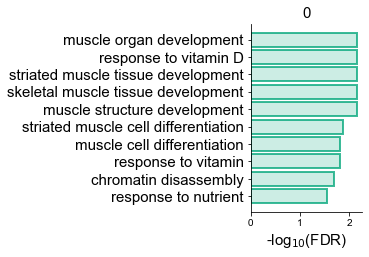

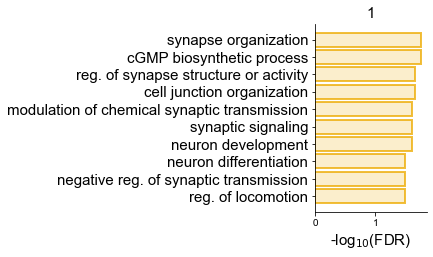

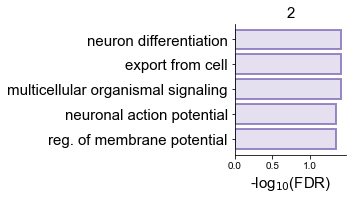

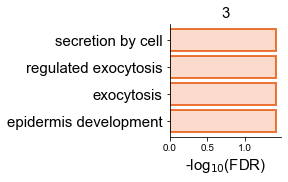

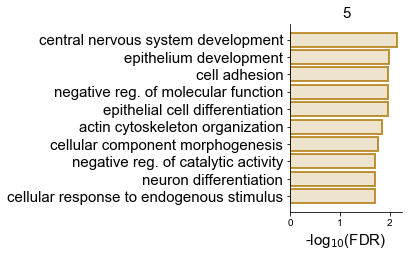

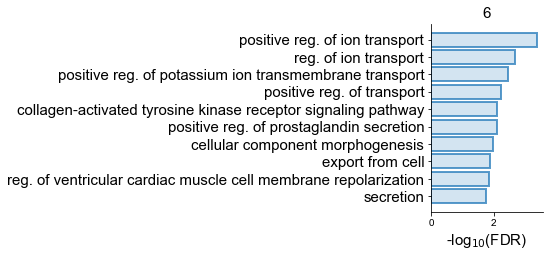

In [15]:
for n in np.unique(list(part.values())):
    go_plot(n)
    plt.savefig(f'./../figs/5B_{n}.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

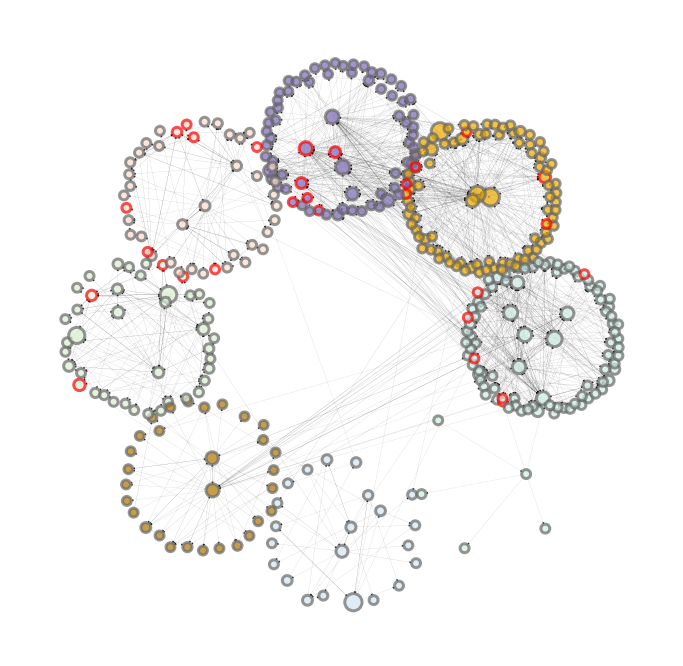

In [16]:
pos = community_layout(DGp, partition=part, scales_c=2.6, scales_n=1.8)
fig, ax = plt.subplots(figsize=(12, 12))
edge_colors = highlight_cmap(list(DGp.nodes()),grntfs)

node_size = np.array(list(nx.betweenness_centrality(DGp, seed=random_s).values()))*8000+80
edge_width = np.array(list(nx.get_edge_attributes(DGp, 'weight').values()))
#cmap = get_cmap(part, highlight=False)
cmap = get_cmap(part, highlight=True, modulelist=[1,2,5], alpha=0.8)
node_color=[cmap[v] for v in list(part.values())]

nodes = nx.draw_networkx_nodes(DGp, pos, node_color=node_color, edgecolors=edge_colors,
                               node_size=node_size, alpha=0.7, linewidths=3)
edges = nx.draw_networkx_edges(DGp, pos, node_size=node_size,
                               width=0.1*edge_width, edge_color='black', arrowsize=5)

ax.set_axis_off()
plt.savefig('./../figs/5B.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

In [17]:
dffig = pd.DataFrame(zip(list(DGp.nodes()), node_size, edge_colors, list(part.values())), 
columns=['geneid', 'rank', 'istf', 'community'])
dffig[dffig['istf']=='#fc0303'].sort_values(by=['rank'], ascending=False)[:3]

,geneid,rank,istf,community
64,HEY1,176.735053,#fc0303,2
24,KLF6,132.277887,#fc0303,1
218,ST18,131.737384,#fc0303,4


In [18]:
dffig[dffig['istf']!='#fc0303'].sort_values(by=['rank'], ascending=False)[:3]

,geneid,rank,istf,community
16,TMEM169,314.617515,#696969,1
75,SCG2,309.902362,#696969,1
211,COL4A2,297.579124,#696969,6


In [19]:
DG = read_directed_grn(f'./../results/GRN/{treatments[2]}_1.txt')
DGp = remove_edge(DG, 0.48, component='positive')
print(f'edges {len(DGp.edges())}')
print(f'nodes {len(DGp.nodes())}')
print(f'''mean weight {np.sum([w for _, _, w in list(DGp.edges.data('weight'))])/len(DGp.edges())}''')
print(f'mean degree {np.sum(list(dict(DGp.degree()).values()))/len(DGp.nodes())}')

edges 1029
nodes 230
mean weight 0.565051707881776
mean degree 8.947826086956521


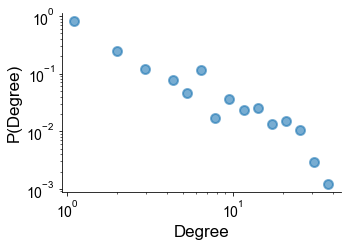

In [20]:
x1, y1 = plot_degree(DGp, n_bins=20)
fig = plt.figure(figsize=(5,3.3))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(x1,y1, 'o', markersize=9, markeredgecolor='tab:blue', markeredgewidth=2, alpha=0.6)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Degree', fontsize=17)
plt.ylabel('P(Degree)', fontsize=17)
plt.savefig('./../figs/S5C.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

In [21]:
part = louvain_cluster(DGp, random_state=True, random_s=random_s)
clustergo(part)

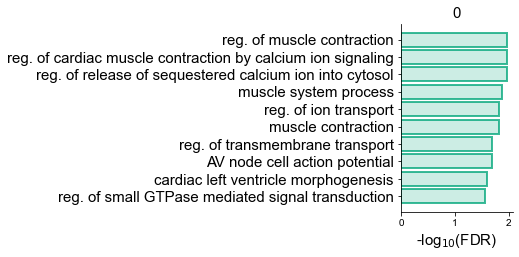

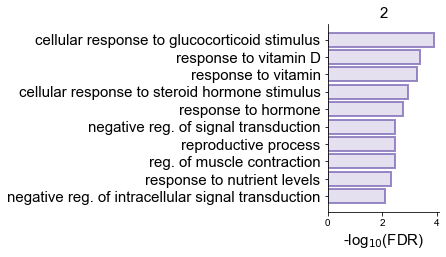

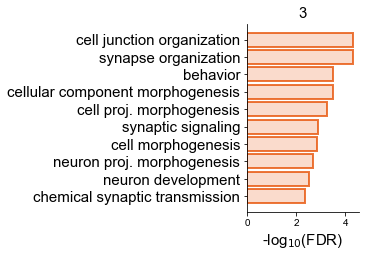

In [22]:
for n in np.unique(list(part.values())):
    go_plot(n)
    plt.savefig(f'./../figs/5C_{n}.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

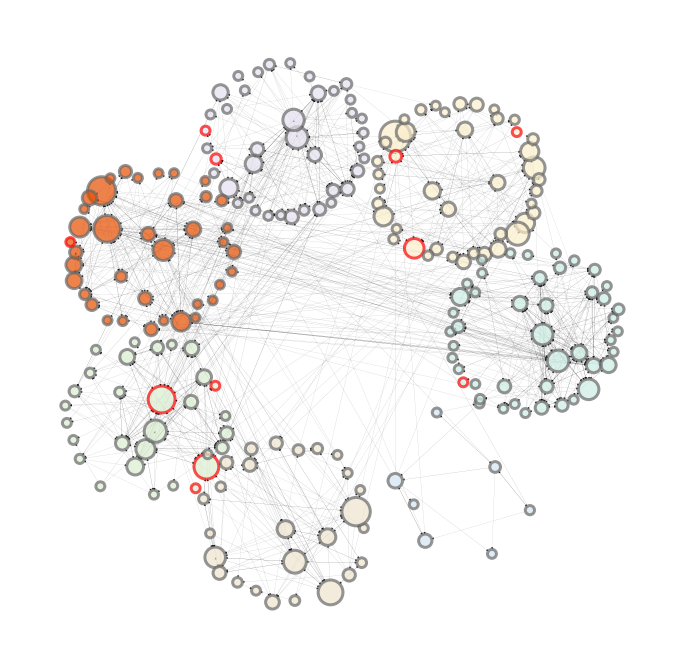

In [23]:
part = louvain_cluster(DGp, random_state=True, random_s=random_s)
pos = community_layout(DGp, partition=part, scales_c=2.4, scales_n=1.8)
fig, ax = plt.subplots(figsize=(12, 12))
edge_colors = highlight_cmap(list(DGp.nodes()),grntfs)

node_size = np.array(list(nx.betweenness_centrality(DGp, seed=random_s).values()))*8000+80
edge_width = np.array(list(nx.get_edge_attributes(DGp, 'weight').values()))
#cmap = get_cmap(part, highlight=False)
cmap = get_cmap(part, highlight=True, modulelist=[3], alpha=0.8)
node_color=[cmap[v] for v in list(part.values())]

nodes = nx.draw_networkx_nodes(DGp, pos, node_color=node_color, edgecolors=edge_colors,
                               node_size=node_size, alpha=0.7, linewidths=3)
edges = nx.draw_networkx_edges(DGp, pos, node_size=node_size,
                               width=0.1*edge_width, edge_color='black', arrowsize=5)

ax.set_axis_off()
plt.savefig('./../figs/5C.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

In [24]:
dffig = pd.DataFrame(zip(list(DGp.nodes()), node_size, edge_colors, list(part.values())), 
columns=['geneid', 'rank', 'istf', 'community'])
dffig[dffig['istf']=='#fc0303'].sort_values(by=['rank'], ascending=False)[:3]

,geneid,rank,istf,community
14,DLX3,722.187055,#fc0303,4
46,NR1D1,614.698668,#fc0303,4
86,ZHX1,384.292084,#fc0303,1


In [25]:
dffig[dffig['istf']!='#fc0303'].sort_values(by=['rank'], ascending=False)[:3]

,geneid,rank,istf,community
50,TTC3,947.515774,#696969,1
139,SHH,806.377391,#696969,5
32,GRP,802.358805,#696969,3


In [26]:
DG = read_directed_grn(f'./../results/GRN/{treatments[3]}_1.txt')
DGp = remove_edge(DG, 0.46, component='positive')
print(f'edges {len(DGp.edges())}')
print(f'nodes {len(DGp.nodes())}')
print(f'''mean weight {np.sum([w for _, _, w in list(DGp.edges.data('weight'))])/len(DGp.edges())}''')
print(f'mean degree {np.sum(list(dict(DGp.degree()).values()))/len(DGp.nodes())}')

edges 1107
nodes 318
mean weight 0.5435396922905067
mean degree 6.962264150943396


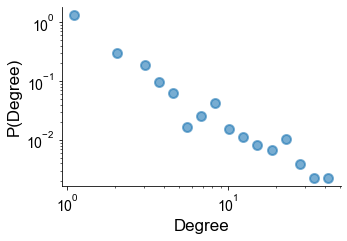

In [27]:
x1, y1 = plot_degree(DGp, n_bins=20)
fig = plt.figure(figsize=(5,3.3))
ax = fig.add_subplot(1, 1, 1)
ax.loglog(x1,y1, 'o', markersize=9, markeredgecolor='tab:blue', markeredgewidth=2, alpha=0.6)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Degree', fontsize=17)
plt.ylabel('P(Degree)', fontsize=17)
plt.savefig('./../figs/S5D.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

In [28]:
part = louvain_cluster(DGp, random_state=True, random_s=random_s)
clustergo(part)

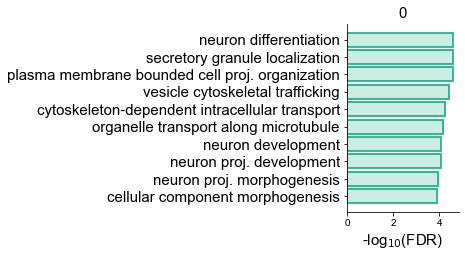

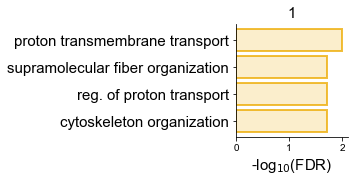

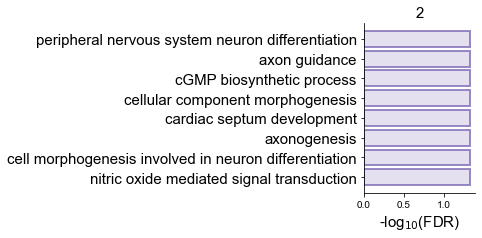

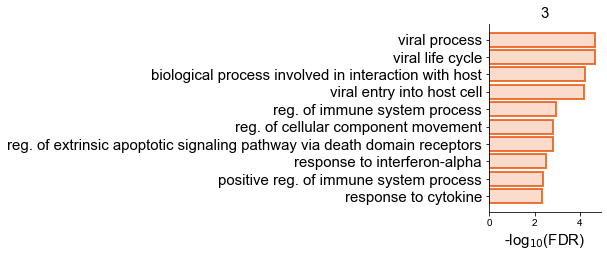

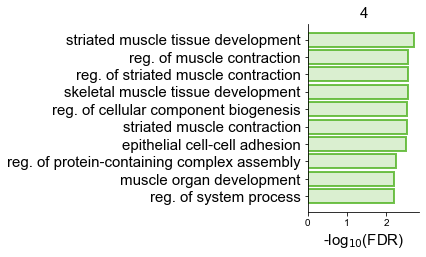

In [29]:
for n in np.unique(list(part.values())):
    go_plot(n)
    plt.savefig(f'./../figs/5D_{n}.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

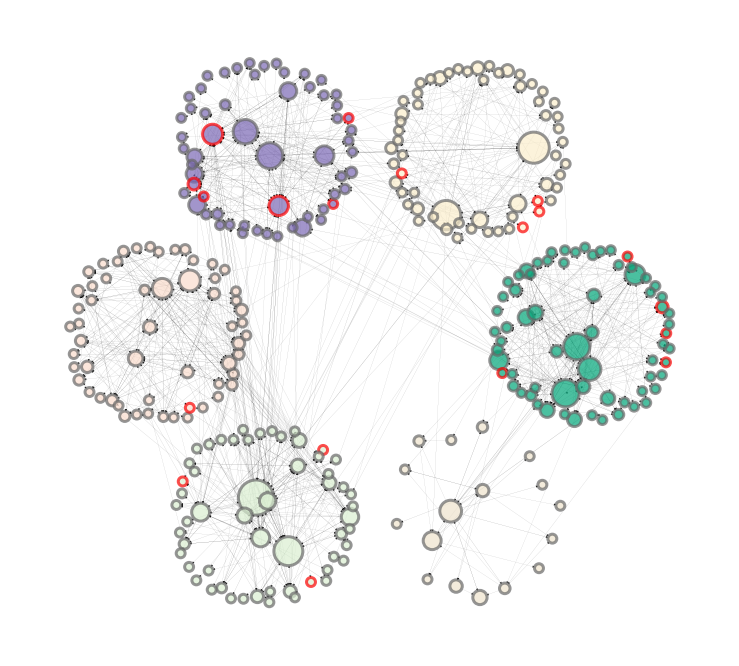

In [30]:
part = louvain_cluster(DGp, random_state=True, random_s=random_s)
pos = community_layout(DGp, partition=part, scales_c=2.4, scales_n=1.8)
fig, ax = plt.subplots(figsize=(13, 12))
edge_colors = highlight_cmap(list(DGp.nodes()),grntfs)

node_size = np.array(list(nx.betweenness_centrality(DGp, seed=random_s).values()))*8000+80
edge_width = np.array(list(nx.get_edge_attributes(DGp, 'weight').values()))
#cmap = get_cmap(part, highlight=False)
cmap = get_cmap(part, highlight=True, modulelist=[0,2], alpha=0.8)
node_color=[cmap[v] for v in list(part.values())]

nodes = nx.draw_networkx_nodes(DGp, pos, node_color=node_color, edgecolors=edge_colors,
                               node_size=node_size, alpha=0.7, linewidths=3)
edges = nx.draw_networkx_edges(DGp, pos, node_size=node_size,
                               width=0.1*edge_width, edge_color='black', arrowsize=5)

ax.set_axis_off()
plt.savefig('./../figs/5D.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

In [31]:
dffig = pd.DataFrame(zip(list(DGp.nodes()), node_size, edge_colors, list(part.values())), 
columns=['geneid', 'rank', 'istf', 'community'])
dffig[dffig['istf']=='#fc0303'].sort_values(by=['rank'], ascending=False)[:3]

,geneid,rank,istf,community
4,LMX1A,399.516037,#fc0303,2
47,PRDM1,373.325574,#fc0303,2
43,ISL1,137.905725,#fc0303,2


In [32]:
dffig[dffig['istf']!='#fc0303'].sort_values(by=['rank'], ascending=False)[:3]

,geneid,rank,istf,community
15,ENO3,1239.241373,#696969,4
91,KANK4,966.090046,#696969,1
11,FSD1,856.124864,#696969,1
